# EVALUATE TOKEN-LEVEL MLM RESULTS

***

## Set Up Analysis

In [2]:
import csv
import pandas as pd
import os
import re
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import matplotlib.font_manager as font_manager
import string

import numpy as np

### Load Test Sets

In [3]:
%%time

test_set_dict = {}

directory = '../../0_data/clean/unlabelled_reddit/error_analysis'
for filename in sorted(os.listdir(directory)):
    if filename.endswith("_5k.csv"):
        print(f"reading {filename}")
        test_set_dict[filename.lstrip("pol_").rstrip(".csv")] = pd.read_csv(os.path.join(directory, filename),
                                                                            converters={"text_ner": literal_eval, 'text_pos': literal_eval,
                                                                                        'text_ner': literal_eval, 'text_tokens': literal_eval,
                                                                                        'tokens_pos': literal_eval, 'tokens_ner': literal_eval})

reading pol_test_2017_03_5k.csv
reading pol_test_2017_04_5k.csv
reading pol_test_2017_05_5k.csv
reading pol_test_2017_06_5k.csv
reading pol_test_2017_07_5k.csv
reading pol_test_2017_08_5k.csv
reading pol_test_2017_09_5k.csv
reading pol_test_2017_10_5k.csv
reading pol_test_2017_11_5k.csv
reading pol_test_2017_12_5k.csv
reading pol_test_2018_01_5k.csv
reading pol_test_2018_02_5k.csv
reading pol_test_2018_03_5k.csv
reading pol_test_2018_04_5k.csv
reading pol_test_2018_05_5k.csv
reading pol_test_2018_06_5k.csv
reading pol_test_2018_07_5k.csv
reading pol_test_2018_08_5k.csv
reading pol_test_2018_09_5k.csv
reading pol_test_2018_10_5k.csv
reading pol_test_2018_11_5k.csv
reading pol_test_2018_12_5k.csv
reading pol_test_2019_01_5k.csv
reading pol_test_2019_02_5k.csv
reading pol_test_2019_03_5k.csv
reading pol_test_2019_04_5k.csv
reading pol_test_2019_05_5k.csv
reading pol_test_2019_06_5k.csv
reading pol_test_2019_07_5k.csv
reading pol_test_2019_08_5k.csv
reading pol_test_2019_09_5k.csv
reading 

### Load Token-Level MLM Results

In [4]:
%%time

mlm_results_dict = {}

directory = '../../0_results/mlm/reddit/token-test/max_seq_128'
for filename in sorted(os.listdir(directory)):
    if filename.endswith("_5k.csv"):
        mlm_results_dict[filename.rstrip(".csv")] = pd.read_csv(os.path.join(directory, filename))

CPU times: user 6.95 s, sys: 1.77 s, total: 8.72 s
Wall time: 17.6 s


### Merge Token-Level MLM Results to Test Sets

In [5]:
full_df_dict = {}

def masked_token_pos(row):
    return row.tokens_pos[row.masked_token_array_id][1]

def masked_token_ner(row):
    return row.tokens_ner[row.masked_token_array_id][1]

def masked_token_ner_binary(row):
    if row.tokens_ner[row.masked_token_array_id][1] != "NO_ENT":
        return "ENT"
    else:
        return "NO_ENT"

# merge info on masked tokens to test_sets
for test_set in test_set_dict:
    print('processing', test_set)
    full_df_dict[test_set] = test_set_dict[test_set].merge(mlm_results_dict[f"bert-base-{test_set}"], how="inner", left_index=True, right_on="case_id")
    full_df_dict[test_set].drop(columns=["ce_loss", "pred_logits", "top_pred_token_vocab_id", "top_pred_token_text"], inplace=True)
    
    full_df_dict[test_set]["masked_token_pos"]=full_df_dict[test_set].apply(lambda x: masked_token_pos(x), axis=1)
    full_df_dict[test_set]["masked_token_ner"]=full_df_dict[test_set].apply(lambda x: masked_token_ner(x), axis=1)
    full_df_dict[test_set]["masked_token_ner_binary"]=full_df_dict[test_set].apply(lambda x: masked_token_ner_binary(x), axis=1)

processing test_2017_03_5k
processing test_2017_04_5k
processing test_2017_05_5k
processing test_2017_06_5k
processing test_2017_07_5k
processing test_2017_08_5k
processing test_2017_09_5k
processing test_2017_10_5k
processing test_2017_11_5k
processing test_2017_12_5k
processing test_2018_01_5k
processing test_2018_02_5k
processing test_2018_03_5k
processing test_2018_04_5k
processing test_2018_05_5k
processing test_2018_06_5k
processing test_2018_07_5k
processing test_2018_08_5k
processing test_2018_09_5k
processing test_2018_10_5k
processing test_2018_11_5k
processing test_2018_12_5k
processing test_2019_01_5k
processing test_2019_02_5k
processing test_2019_03_5k
processing test_2019_04_5k
processing test_2019_05_5k
processing test_2019_06_5k
processing test_2019_07_5k
processing test_2019_08_5k
processing test_2019_09_5k
processing test_2019_10_5k
processing test_2019_11_5k
processing test_2019_12_5k
processing test_2020_01_5k
processing test_2020_02_5k


In [6]:
# merge model ce_losses
for test_set in full_df_dict:
    n_rows = full_df_dict[test_set].shape[0]
    for result in sorted(mlm_results_dict):
        if test_set in result:
            if mlm_results_dict[result].shape[0] == n_rows:
                if ("base" in result) or ("rand_1m" in result):
                    full_df_dict[test_set] = full_df_dict[test_set].merge(mlm_results_dict[result]["ce_loss"].rename("ce_{}".format(re.search("bert-(.*?)-test(.*?)",result).group(1))),
                                                                              how="inner", left_index=True, right_index=True)
                else:
                    full_df_dict[test_set] = full_df_dict[test_set].merge(mlm_results_dict[result]["ce_loss"].rename("ce_match_1m"),
                                                          how="inner", left_index=True, right_index=True)
            else: 
                print(f"{result} results do not match number of rows in test set")

In [7]:
# clear up RAM
del mlm_results_dict
del test_set_dict

***

# MAIN ANALYSIS

### Concatenate monthly results into single dataframe

In [8]:
for key in full_df_dict:
    full_df_dict[key]["source"] = key

overall_df = pd.concat(full_df_dict.values(), ignore_index=True)

### Clean POS errors in small classes


In [9]:
valid_pos={}

valid_pos["PART"]=["to", "'", "not", "s", "’"]
valid_pos["PUNCT"] = list(string.punctuation + "’" + "“"+ "”" + "‘" + "—")
valid_pos["CCONJ"] = ['and', 'but', 'or', '&', 'either', 'so', 'nor', 'both', 'plus', 'yet', 'neither']

for pos in valid_pos:
    mask = (overall_df.masked_token_pos == pos)&(overall_df.masked_token_text.apply(lambda x: x not in valid_pos[pos]))
    print(f"dropping {mask.sum()} invalid {pos} tokens")
    overall_df = overall_df[~mask]

dropping 16 invalid PART tokens
dropping 1289 invalid PUNCT tokens
dropping 99 invalid CCONJ tokens


### BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

In [10]:
# BASE VS RAND: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

# first column is number of tokens by POS tag
calc_df = pd.DataFrame(overall_df.groupby("masked_token_pos").tokens_pos.count()).merge(overall_df.groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)

# merge rand adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)

# merge match adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_match_1m.sum(), left_index=True, right_index=True)

calc_df = calc_df.sort_values("tokens_pos", ascending=False)

calc_df["diff_base_rand_sum"] = calc_df.iloc[:,1]-calc_df.iloc[:,2]
calc_df["diff_base_rand_mean"] = calc_df["diff_base_rand_sum"]/calc_df["tokens_pos"]
calc_df["diff_base_rand_pct"] = (calc_df.iloc[:,1]-calc_df.iloc[:,2])/calc_df.iloc[:,1]
calc_df = calc_df[["tokens_pos", "diff_base_rand_sum", "diff_base_rand_mean", "diff_base_rand_pct"]]

# drop rare unknown and symbol tokens
calc_df.drop(["X", "SYM"], inplace=True)


display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

,tokens_pos,diff_base_rand_sum,diff_base_rand_mean,diff_base_rand_pct
masked_token_pos,,,,
NOUN,185436,227276.01,1.23,0.28
VERB,141077,178069.61,1.26,0.33
PUNCT,116698,118238.60,1.01,0.54
PRON,86932,51395.14,0.59,0.31
DET,83225,35248.90,0.42,0.27
ADP,76139,36029.35,0.47,0.26
ADJ,71408,75059.50,1.05,0.24
ADV,57817,57781.95,1.00,0.26
AUX,56866,54384.74,0.96,0.51


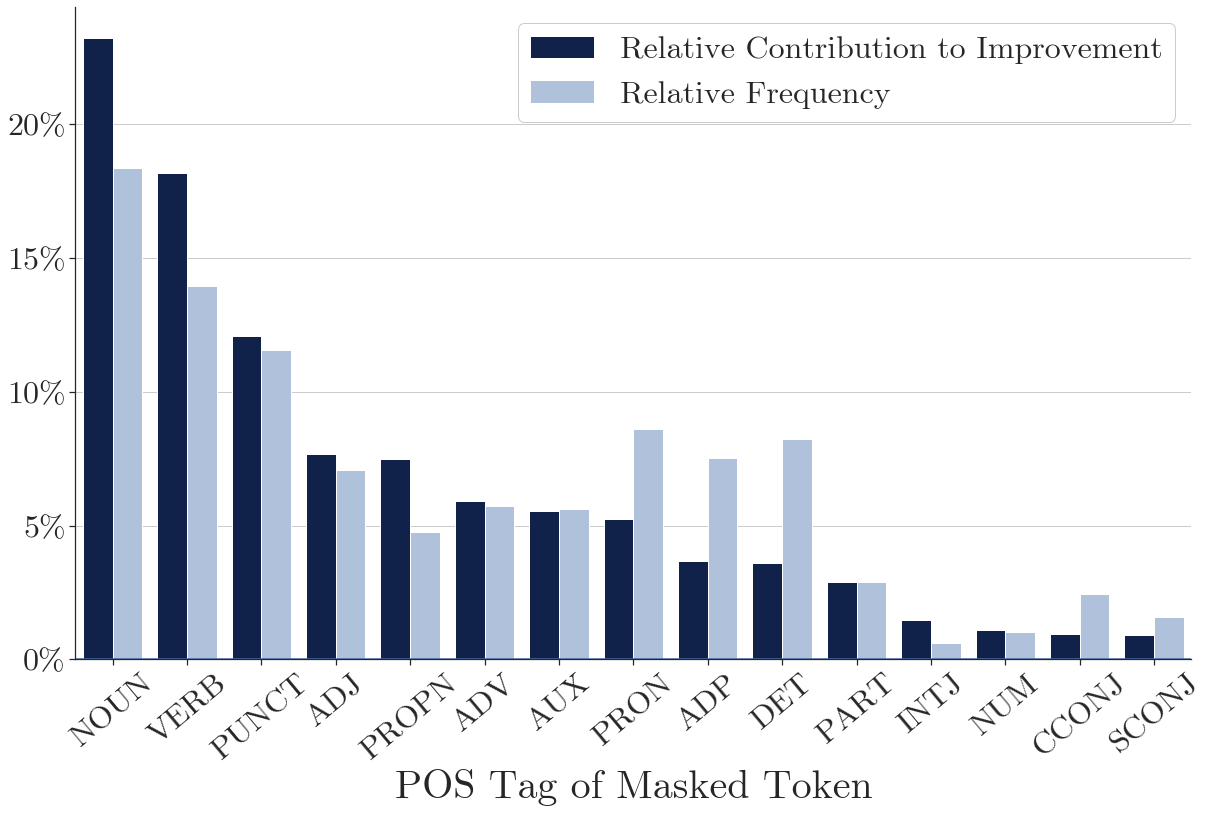

In [11]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False


calc_df["prop_token"] = calc_df.iloc[:,0]/calc_df.iloc[:,0].sum()
calc_df["prop_improvement"] = calc_df.iloc[:,1]/calc_df.iloc[:,1].sum()
tidy_df = calc_df[["prop_improvement", "prop_token"]].sort_values("prop_improvement", ascending=False).reset_index().melt(id_vars="masked_token_pos").rename(columns=str.title)

fig, ax = plt.subplots(figsize=(20, 12))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))

# create seaborn plot
colors = ["#071e54", "#a8c0e2"]
ax=sns.barplot(x='Masked_Token_Pos', y='Value', hue='Variable', data=tidy_df, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='POS Tag of Masked Token', ylabel='')

# configure legend
legend = ax.legend(framealpha=1,  prop={'size': 32})
legend.get_texts()[0].set_text("Relative Contribution to Improvement")
legend.get_texts()[1].set_text("Relative Frequency")

# set font sizes
ax.xaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

sns.despine(fig)

ax.axhline()

plt.xticks(rotation = 40)

plt.show()

### RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

In [12]:
# RAND VS MATCH: Improvement in sum of CE and avg. CE loss by POS tag

cm = sns.color_palette('Greens', as_cmap=True)

# first column is number of tokens by POS tag
calc_df = pd.DataFrame(overall_df.groupby("masked_token_pos").tokens_pos.count()).merge(overall_df.groupby("masked_token_pos").ce_base.sum(), left_index=True, right_index=True)

# merge rand adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_rand_1m.sum(), left_index=True, right_index=True)

# merge match adapted model
calc_df = calc_df.merge(overall_df.groupby("masked_token_pos").ce_match_1m.sum(), left_index=True, right_index=True)

calc_df = calc_df.sort_values("tokens_pos", ascending=False)

calc_df["diff_rand_match_sum"] = calc_df.iloc[:,2]-calc_df.iloc[:,3]
calc_df["diff_rand_match_mean"] = calc_df["diff_rand_match_sum"]/calc_df["tokens_pos"]
calc_df["diff_rand_match_pct"] = (calc_df.iloc[:,2]-calc_df.iloc[:,3])/calc_df.iloc[:,2]
calc_df = calc_df[["tokens_pos", "diff_rand_match_sum", "diff_rand_match_mean", "diff_rand_match_pct"]]

# drop rare unknown and symbol tokens
calc_df.drop(["X", "SYM"], inplace=True)

display(calc_df.style.background_gradient(cmap=cm, axis = 0, subset=calc_df.columns[1:]).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').set_precision(2))

,tokens_pos,diff_rand_match_sum,diff_rand_match_mean,diff_rand_match_pct
masked_token_pos,,,,
NOUN,185436,2367.25,0.01,0.00
VERB,141077,1102.50,0.01,0.00
PUNCT,116698,-251.23,-0.00,-0.00
PRON,86932,136.86,0.00,0.00
DET,83225,772.27,0.01,0.01
ADP,76139,137.38,0.00,0.00
ADJ,71408,115.33,0.00,0.00
ADV,57817,418.21,0.01,0.00
AUX,56866,362.43,0.01,0.01


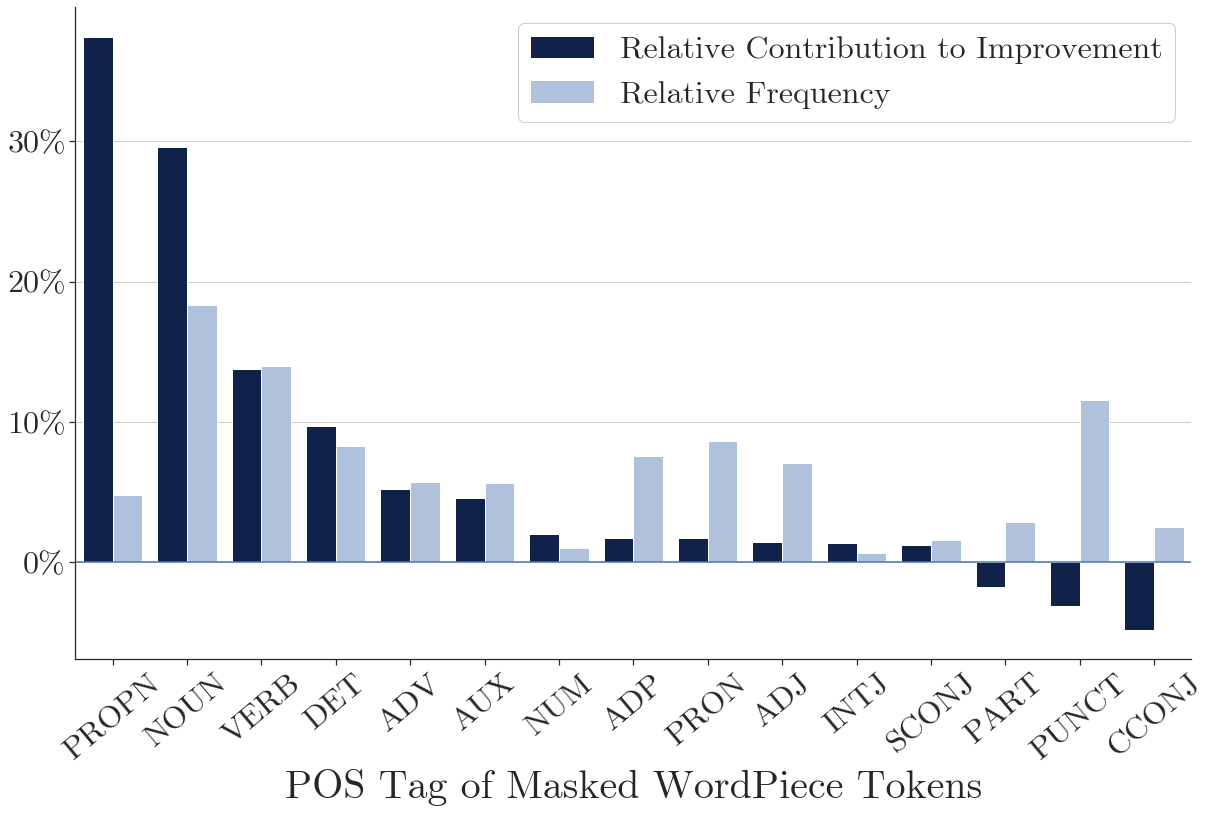

In [16]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False


calc_df["prop_token"] = calc_df.iloc[:,0]/calc_df.iloc[:,0].sum()
calc_df["prop_improvement"] = calc_df.iloc[:,1]/calc_df.iloc[:,1].sum()
tidy_df = calc_df[["prop_improvement", "prop_token"]].sort_values("prop_improvement", ascending=False).reset_index().melt(id_vars="masked_token_pos").rename(columns=str.title)

fig, ax = plt.subplots(figsize=(20, 12))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))

# create seaborn plot
colors = ["#071e54", "#a8c0e2"]
ax=sns.barplot(x='Masked_Token_Pos', y='Value', hue='Variable', data=tidy_df, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='POS Tag of Masked WordPiece Tokens', ylabel='')

# configure legend
legend = ax.legend(framealpha=1,  prop={'size': 32})
legend.get_texts()[0].set_text("Relative Contribution to Improvement")
legend.get_texts()[1].set_text("Relative Frequency")

# set font sizes
ax.xaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

sns.despine(fig)

ax.axhline()

plt.xticks(rotation = 40)

plt.show()

In [150]:
# number of masked tokens:
overall_df.shape[0]

1013758

### What is the distribution of improvements across PROPNs?

In [14]:
%%time

top_df = overall_df[overall_df.masked_token_pos=="PROPN"][["case_id", "text", "masked_token_text", "ce_base", "ce_rand_1m", "ce_match_1m", "source"]].copy()
top_df["ce_diff_rand_match"] = top_df.ce_rand_1m - top_df.ce_match_1m
top_df["ce_diff_base_rand"] = top_df.ce_base - top_df.ce_rand_1m
top_df["ce_diff_base_match"] = top_df.ce_base - top_df.ce_match_1m

bins = []
sums = []

for inc in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    subset_improvement = top_df.ce_diff_rand_match.sort_values(ascending=False)[int(top_df.shape[0]*(inc-0.1)):int(top_df.shape[0]*inc)].sum()
    overall_improvement = top_df.ce_diff_rand_match.sum()
    bins.append(int(inc*10))
    sums.append(subset_improvement/overall_improvement)

CPU times: user 601 ms, sys: 3.99 s, total: 4.59 s
Wall time: 8.22 s


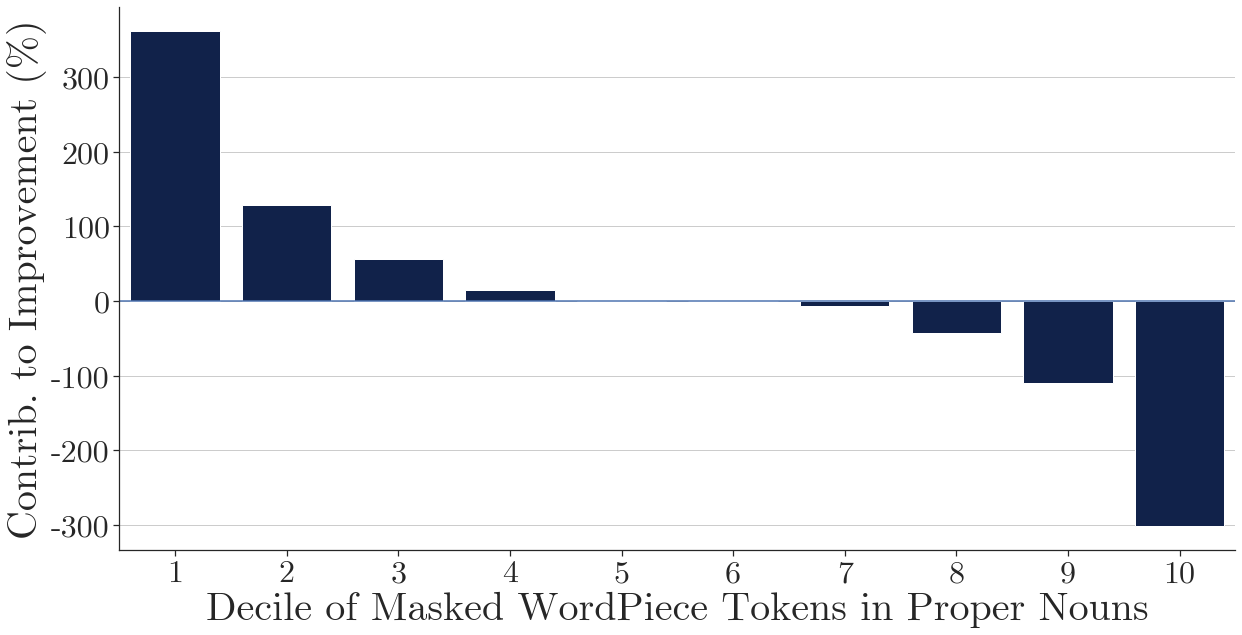

In [17]:
### Plot: Double Bar - Proportion of Tokens & Proportion of Improvement

sns.set_theme(font="CMU Serif", style="ticks", font_scale=1.1)
matplotlib.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(20, 10))

# show grid behind bars
ax.set_axisbelow(True)
ax.grid(which="both")

# set y axis to pct
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0, symbol=""))

# create seaborn plot
colors = ["#071e54"]
ax=sns.barplot(x=bins, y=sums, ax=ax, palette=sns.color_palette(colors))

# set x and y labels
ax.set(xlabel='Decile of Masked WordPiece Tokens in Proper Nouns', ylabel='Contrib. to Improvement (%)')

# set font sizes
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.tick_params(axis='x',labelsize= 32)
ax.tick_params(axis='y',labelsize= 32)

ax.axhline()

sns.despine(fig)

plt.show()

In [293]:
top_df.shape[0]

48107

### Which proper nouns had large improvements through temporal adaptation?

In [295]:
## display top 10

out_df = top_df[top_df.ce_rand_1m<top_df.ce_base].sort_values("ce_diff_rand_match", ascending=False).head(10)

pd.set_option('display.max_colwidth', None)
#display(out_df)
pd.reset_option('display.max_colwidth')

,case_id,text,masked_token_text,ce_base,ce_rand_1m,ce_match_1m,source,ce_diff_rand_match,ce_diff_base_rand,ce_diff_base_match
1001613,2390,What is Newsom's plan if 2019-nCov escapes quarantine? Or is that his plan for the homeless?,nc,14.097670,11.923356,0.001382,test_2020_02_5k,11.921974,2.174314,14.096287
383247,4092,"I'm actually shocked that Trump didn't fire Tillerson after the moron comment. I said it somewhere else, but I'm pretty convinced that Trump is addicted to firing people, and couldn't let go of that mindset from reality show to White House.",##erson,13.570045,11.193896,0.000115,test_2018_03_5k,11.193781,2.376148,13.569930
310205,1552,"we can still say that we expected better from Aziz Ansari It's none of your business, that's my opinion.",aziz,17.461544,10.650843,0.079531,test_2018_01_5k,10.571312,6.810701,17.382013
721673,267,"In a related story, gun possession charges have been filed against the security guard by Kim Foxx.",kim,11.265576,10.409239,0.404922,test_2019_04_5k,10.004317,0.856338,10.860655
914700,1079,"Guys, you're not getting the point. Female trans/genderfluid/non-binary PoCs are the backbone of our democracy (pretty much the EXACT Warren quote). We must give them their proper representation in government.. And you're all misogynistic if you hate this idea. REEEEEEEEEEEEEE",warren,14.126513,10.785352,1.243608,test_2019_11_5k,9.541744,3.341162,12.882905
834947,1371,"McConnell has embraced the ""Grim Reaper"" label. He tells his supporters he's proud to kill ""liberal, socialist policies"" presented by Democrats. ""Moscow Mitch,"" on the other hand, he seemingly despises.",moscow,12.887622,9.687475,0.649284,test_2019_08_5k,9.038191,3.200147,12.238338
355583,4358,"When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like lobertarians, instead of having good ideas and being able to get teh sex. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Drumfpsterdoodles, instead of having good ideas and being able to get in the White House. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Tide pod eaters, instead of having good ideas and being able to get into the washing machine. When you realize there are people with such a weak ideology that they spend their time picking on an imaginary ""active political group"" like Velociraptors Opening Doors, instead of having good ideas and being able to get into the control room ah ah ahhh, ah ah ahhh, ah ah ahhh. Spared no expense! When you realize there are people with su",tide,9.700526,8.788287,0.026859,test_2018_02_5k,8.761428,0.912239,9.673668
180600,4733,"How does the women's march fit into this whole thing? As far as I can tell libs were behind it 100%. What were the differences between it and Cville? Are libs really beating up on Antifa that much? I can't really figure out which way is up anymore in the media landscape so I'm not quite sure if Chapo is calling out a large trend or just some fringe assholes. Also, my (admittedly thin) knowledge of the civil rights era and protests understands the non-violence/turn the other cheek approach that MLK pursued to be far and away the most effective method of protest in US history. Is that an accurate characterization of that time, and if so, should we push for public action more along those lines instead of the more militant style of Antifa? I'm afraid fights of completely legitimate self defense will nonetheless get processed by 1/2 the country as aggression. Bodily self sacrifice is much harder to spin though I think. Welcome any correction/criticism of this, just trying to work things out in my head.",cv,11.515744,11.293634,2.783820,test_2017_08_5k,8.509815,0.222110,8.731925
442483,4288,"How can a neo\-Nazi slogan pre\-date the original Nazism? W

In [302]:
# write top 10% tokens and test_month to pickle
export_df = top_df.sort_values("ce_diff_rand_match", ascending=False)[["masked_token_text", "source", "ce_diff_rand_match", "ce_base", "ce_rand_1m", "ce_match_1m"]]
export_df.to_csv("../../0_data/clean/labelled_reddit/error_analysis/most_improved_propn.csv", index=False)